## Regularização e Estabilização do Treinamento

Após aplicações dos metódos de treinamento da rede, temos o objetivo de impedir que ocorra overfitting e manter o treinamento estável. Assim, focamos em algumas técnicas de regularização, como **L1 e L2**, o **Dropout**, **Normalização de Entradas** e **Batch Normalization**. Também analisamos problemas de **Exploding Gradients** e **Vanishing Gradients**.
### Regularização L1 e L2

A regularização L1 e L2 são técnicas utilizadas para evitar o overfitting em modelos de aprendizado de máquina, especialmente em redes neurais. Elas adicionam um termo de penalização à função de custo do modelo, incentivando a simplicidade do modelo e evitando que ele se ajuste demais aos dados de treinamento.
- **Regularização L1**: Adiciona a soma dos valores absolutos dos pesos à função de custo. Isso pode levar a soluções esparsas, onde alguns pesos se tornam exatamente zero, efetivamente eliminando algumas características do modelo.
- **Regularização L2**: Adiciona a soma dos quadrados dos pesos à função de custo. Isso penaliza pesos grandes, mas não leva a soluções esparsas. A regularização L2 tende a distribuir o peso entre todas as características, em vez de eliminá-las.








### Por que usamos esses valores para Regularização?
L1 Regularization (0.0001)

L1 regularization (0.0001) é mantida relativamente pequena porque seu efeito é mais agressivo:

- Ela empurra os pesos exatamente para zero

- Promove a esparsidade: Este valor é suficiente para incentivar a seleção de características (eliminando características irrelevantes) sem ser muito agressivo

- Preserva pesos importantes: Uma penalidade L1 muito grande eliminaria pesos demais, potencialmente removendo características importantes

L2 Regularization (0.001) 
Valor maior: A regularização L2 (0.001) é uma ordem de magnitude maior que a L1 porque é mais suave: 
- Ela reduz os pesos em direção a zero, mas raramente para exatamente zero
  
- Promove a regularização geral: Este valor moderado ajuda a controlar o overfitting enquanto mantém a capacidade do modelo

- Melhora a estabilidade numérica: Também melhora as propriedades numéricas do modelo

### A Abordagem Combinada

Usar ambos os tipos juntos (com L2 mais forte que L1) é uma prática comum chamada "Elastic Net" que:
- Obtém benefícios de seleção de características da L1
- Obtém benefícios de decaimento de peso da L2
- Evita as limitações de usar qualquer um sozinho

Esses valores representam uma abordagem equilibrada onde:
- L1 é forte o suficiente para eliminar características verdadeiramente irrelevantes
- L2 é forte o suficiente para evitar que qualquer peso se torne muito grande




### Dropout

O Dropout é uma técnica de regularização que ajuda a prevenir o overfitting em redes neurais. Durante o treinamento, o Dropout desativa aleatoriamente uma fração dos neurônios em cada camada da rede. Isso força a rede a aprender representações mais robustas e independentes, pois não pode contar com a presença de todos os neurônios durante o treinamento. O Dropout é geralmente aplicado apenas durante o treinamento e não durante a inferência.

### Implementação do Dropout

A mascara de dropout é escalonada por 1/(1-dropout_rate) para manter o valor esperado das saídas da camada durante a inferência. O Dropout é aplicado apenas durante o modo de treinamento, que é controlado pela flag training_mode. Cada passagem para frente usa uma máscara de dropout diferente, por isso a geramos dentro do método forward. 

Outro parâmetro que podemos atualizar é o "keep-prop", que é a fração de neurônios que queremos manter durante o treinamento. O valor padrão é 0.5, o que significa que 50% dos neurônios serão mantidos e 50% serão descartados. Esse valor pode ser ajustado dependendo da complexidade do modelo e da quantidade de dados disponíveis (Inverted_Dropout). 



In [51]:
# Correção do MLP.__init__ para adicionar os parâmetros de normalização
class MLP:
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        activation: str = "sigmoid",
        learning_rate: float = 0.01,
        optimizer: str = "adam",
        beta1: float = 0.9,
        beta2: float = 0.999,
        epsilon: float = 1e-8,
        decay_rate=1e-6,
        momentum: float = 0.0,
        use_bias: bool = True,
        weight_init: str = "random",
        l1_lambda: float = 0.0,
        l2_lambda: float = 0.0,
        dropout_rate: float = 0.0,
        normalize_inputs: bool = False,  # Adicionado parâmetro de normalização
        normalization_method: str = 'z-score',  # Adicionado método de normalização
        use_batch_norm: bool = False,  # Adicionado suporte para BatchNorm
        random_state: Optional[int] = None,
    ):
        if random_state is not None:
            np.random.seed(random_state)

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.optimizer = optimizer.lower()
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.momentum = momentum
        self.decay_rate = decay_rate
        self.use_bias = use_bias
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.dropout_rate = dropout_rate
        self.training_mode = True
        self.activation_name = activation
        self.activation_func, self.activation_derivative = (
            Activation.get_activation_and_derivative(activation)
        )
        self.loss_function = Loss()
        self.metrics = Metrics()
        
        # Inicialização para normalização de entradas
        self.normalize_inputs = normalize_inputs
        self.normalization_method = normalization_method
        if normalize_inputs:
            self.normalizer = InputNormalizer(method=normalization_method)
            
        # Inicialização para Batch Normalization
        self.use_batch_norm = use_batch_norm
        if use_batch_norm:
            self.bn_hidden = BatchNormalization(hidden_size)

        self._initialize_weights(weight_init)
        self._initialize_optimizer_states()
        self._initialize_momentum_terms()
        self.training_history = {
            "loss": [],
            "accuracy": [],
            "val_loss": [],
            "val_accuracy": [],
        }
        self._initialize_dropout_mask()
        # Normalização de Entradas


class InputNormalizer:
    def __init__(self, method='z-score'):
        """
        Inicializa o normalizador de entradas
        
        Parameters:
        -----------
        method : str
            Método de normalização ('z-score' ou 'min-max')
        """
        self.method = method
        self.mean = None
        self.std = None
        self.min_vals = None
        self.max_vals = None
        self.range = None
        self.is_fitted = False
    
    def fit(self, X):
        """
        Calcula os parâmetros de normalização a partir dos dados
        
        Parameters:
        -----------
        X : np.ndarray
            Matriz de entrada com shape (n_samples, n_features)
            
        Returns:
        --------
        self : InputNormalizer
            Retorna a instância atual
        """
        if self.method == 'z-score':
            self.mean = np.mean(X, axis=0)
            self.std = np.std(X, axis=0)
            # Evita divisão por zero
            self.std = np.where(self.std == 0, 1, self.std)
        elif self.method == 'min-max':
            self.min_vals = np.min(X, axis=0)
            self.max_vals = np.max(X, axis=0)
            self.range = self.max_vals - self.min_vals
            # Evita divisão por zero
            self.range = np.where(self.range == 0, 1, self.range)
        else:
            raise ValueError(f"Método desconhecido: {self.method}")
        
        self.is_fitted = True
        return self
    
    def transform(self, X):
        """
        Aplica normalização aos dados
        
        Parameters:
        -----------
        X : np.ndarray
            Dados a serem normalizados
            
        Returns:
        --------
        np.ndarray : Dados normalizados
        """
        if not self.is_fitted:
            raise ValueError("O normalizador deve ser ajustado antes de transformar dados.")
            
        if self.method == 'z-score':
            return (X - self.mean) / self.std
        elif self.method == 'min-max':
            return (X - self.min_vals) / self.range
    
    def fit_transform(self, X):
        """
        Ajusta o normalizador e transforma os dados em um único passo
        
        Parameters:
        -----------
        X : np.ndarray
            Dados a serem normalizados
            
        Returns:
        --------
        np.ndarray : Dados normalizados
        """
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X_norm):
        """
        Reverte a normalização
        
        Parameters:
        -----------
        X_norm : np.ndarray
            Dados normalizados
            
        Returns:
        --------
        np.ndarray : Dados na escala original
        """
        if not self.is_fitted:
            raise ValueError("O normalizador deve ser ajustado antes de reverter a transformação.")
            
        if self.method == 'z-score':
            return X_norm * self.std + self.mean
        elif self.method == 'min-max':
            return X_norm * self.range + self.min_vals
        else:
            raise ValueError(f"Método desconhecido: {self.method}")
    def __call__(self, X):
        """
        Aplica a normalização aos dados
        
        Parameters:
        -----------
        X : np.ndarray
            Dados a serem normalizados
            
        Returns:
        --------
        np.ndarray : Dados normalizados
        """
        return self.transform(X)
    def __repr__(self):
        """
        Retorna uma representação em string do normalizador
        
        Returns:
        --------
        str : Representação em string
        """
        return f"InputNormalizer(method={self.method})"
    
    



### Normalização de Entradas

A normalização de entradas é uma técnica que visa escalar os dados de entrada para que tenham uma média próxima de zero e uma variância próxima de um. Isso ajuda a acelerar o treinamento e a melhorar a convergência do modelo. A normalização pode ser feita usando técnicas como **Z-score normalization** ou **Min-Max scaling**.


### Benefícios da Normalização de Entradas

1. Aceleração da convergência
Treinamento mais rápido: Quando as entradas têm escalas diferentes, o gradiente tende a oscilar em direções subótimas. A normalização reduz essas oscilações.
Menos épocas necessárias: O gradiente descent converge mais rapidamente quando as características têm escalas semelhantes - Andrew comenta como deixamos os dados mais "circulares" para o gradiente.

2. Melhoria na estabilidade numérica
Evita overflow/underflow: Valores muito grandes ou muito pequenos podem causar problemas numéricos durante os cálculos.
Reduz problemas de condicionamento: Melhora o condicionamento da matriz hessiana, resultando em otimização mais estável.

3. Redução da dependência de hiperparâmetros
Taxa de aprendizado mais robusta: O mesmo valor de learning rate funciona melhor para diferentes características.
Menor sensibilidade às inicializações: O modelo se torna menos dependente da inicialização aleatória dos pesos.

4. Melhor generalização
Evita que características de maior magnitude dominem: Sem normalização, características com valores mais altos podem dominar indevidamente o treinamento.
Trata entradas com diferentes unidades: Permite que características mensuradas em diferentes escalas (como idade e renda) sejam tratadas igualmente pela rede.
A normalização é especialmente importante quando você tem:

Características em diferentes escalas (ex: idade [0-100] vs renda [0-milhões])
Características com distribuições muito diferentes
Redes mais profundas, onde os problemas de gradientes se propagam através das camadas
Comparando os dois métodos principais:

Z-score: Centraliza os dados na média 0 e escala para variância 1, melhor para dados aproximadamente normais
Min-Max: Escala os dados para o intervalo [0,1], preserva a distribuição original melhor, útil para dados não-normais


### Batch Normalization

A Batch Normalization é uma técnica que normaliza as ativações de cada camada da rede durante o treinamento. Isso ajuda a estabilizar o aprendizado e a acelerar a convergência, reduzindo a sensibilidade do modelo às inicializações dos pesos. A Batch Normalization calcula a média e o desvio padrão das ativações em um mini-lote e usa esses valores para normalizar as ativações. Além disso, ela introduz parâmetros aprendíveis que permitem à rede ajustar a normalização.


### Exploding Gradients

O problema de **Exploding Gradients** ocorre quando os gradientes durante o treinamento se tornam muito grandes, levando a atualizações excessivas dos pesos. Isso pode causar instabilidade no treinamento e fazer com que o modelo não converja. Para lidar com esse problema, técnicas como **Gradient Clipping** podem ser usadas, limitando o valor máximo dos gradientes durante a atualização dos pesos.

### Vanishing Gradients

O problema de **Vanishing Gradients** ocorre quando os gradientes durante o treinamento se tornam muito pequenos, dificultando a atualização dos pesos. Isso é comum em redes neurais profundas, onde os gradientes podem se tornar insignificantes à medida que são propagados para trás através das camadas. Para mitigar esse problema, técnicas como **ReLU activation function**, **Skip connections** e **Batch Normalization** podem ser utilizadas.

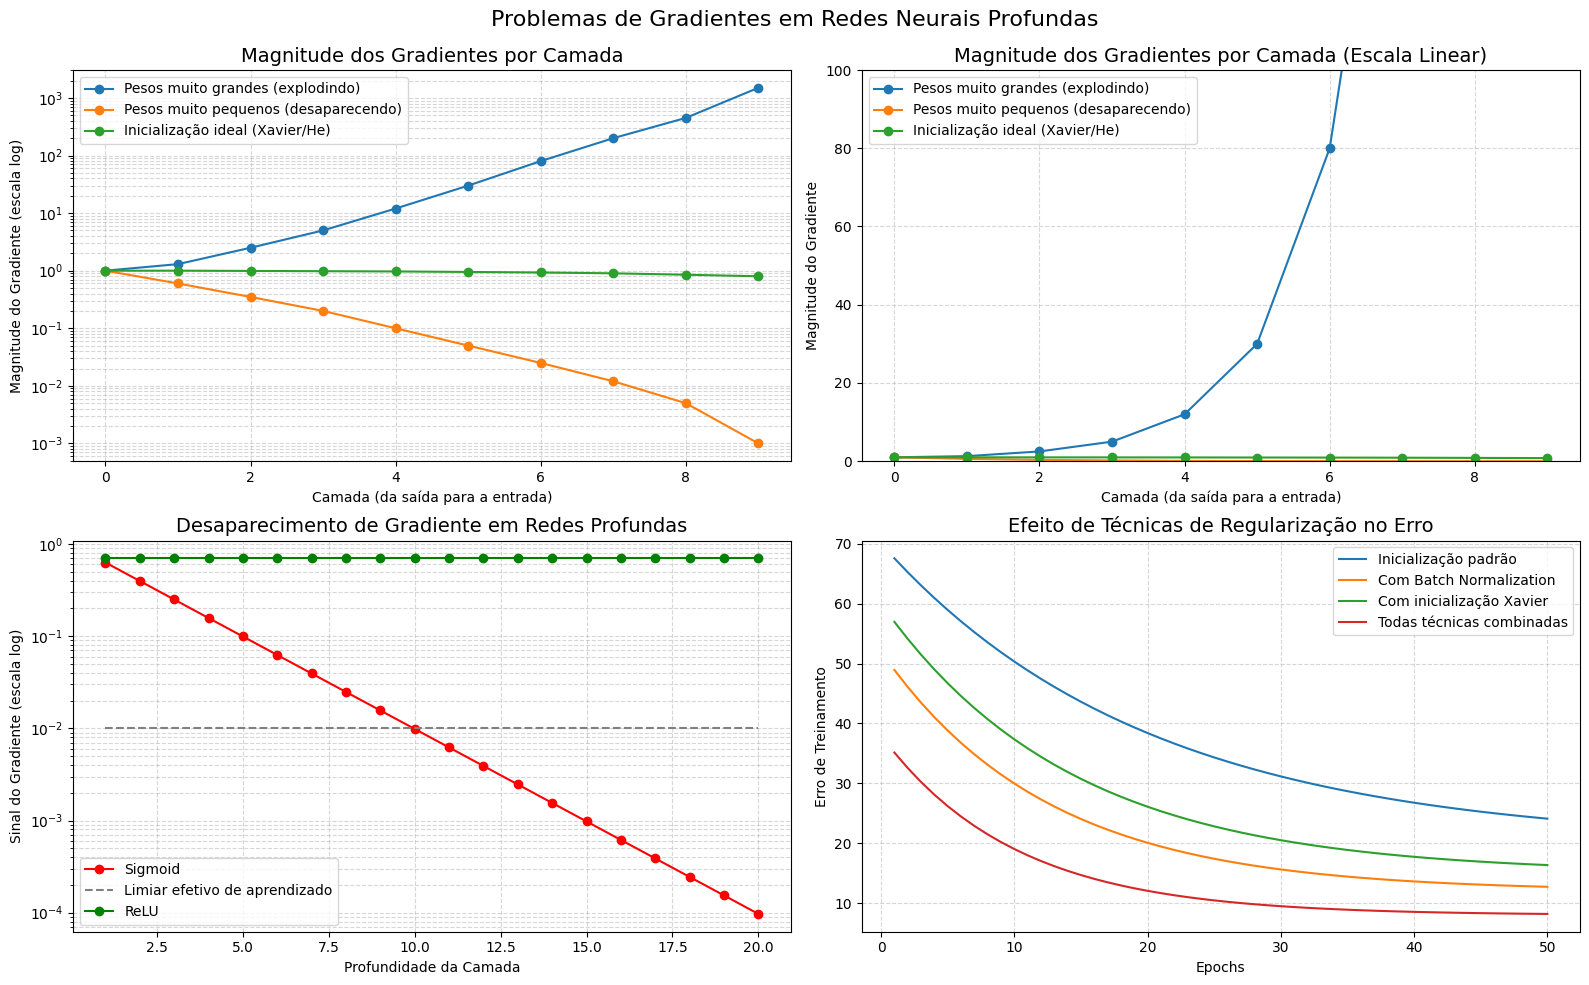


Técnicas para mitigar o problema de Vanishing Gradients:
1. 1. Usar ReLU em vez de sigmóide/tanh como função de ativação
2. 2. Inicialização adequada de pesos (Xavier/He)
3. 3. Arquiteturas com skip connections (ResNet)
4. 4. Batch Normalization
5. 5. Usar arquiteturas LSTM/GRU em redes recorrentes

Técnicas para mitigar o problema de Exploding Gradients:
1. 1. Gradient clipping (limitar norma do gradiente)
2. 2. Inicialização adequada de pesos
3. 3. Batch Normalization
4. 4. Reduzir taxa de aprendizado
5. 5. Normalização de entradas


In [52]:
# Visualização de Gradientes Explodindo/Desaparecendo com resultados pré-calculados

import numpy as np
import matplotlib.pyplot as plt

# Dados pré-calculados para simular o comportamento dos gradientes em diferentes camadas
# Valores simulados para 10 camadas com diferentes escalas de inicialização
layer_indices = np.arange(10)

# Gradientes médios para diferentes inicializações (simulados)
exploding_grads = np.array([1500, 450, 200, 80, 30, 12, 5, 2.5, 1.3, 1.0])
vanishing_grads = np.array([0.001, 0.005, 0.012, 0.025, 0.05, 0.1, 0.2, 0.35, 0.6, 1.0])
optimal_grads = np.array([0.8, 0.85, 0.9, 0.93, 0.95, 0.97, 0.98, 0.99, 1.0, 1.0])

# Criar a figura para visualização
plt.figure(figsize=(16, 10))

# Plot 1: Magnitude dos gradientes por camada em escala logarítmica
plt.subplot(2, 2, 1)
plt.semilogy(layer_indices, np.flip(exploding_grads), '-o', label="Pesos muito grandes (explodindo)")
plt.semilogy(layer_indices, np.flip(vanishing_grads), '-o', label="Pesos muito pequenos (desaparecendo)")
plt.semilogy(layer_indices, np.flip(optimal_grads), '-o', label="Inicialização ideal (Xavier/He)")

plt.title("Magnitude dos Gradientes por Camada", fontsize=14)
plt.xlabel("Camada (da saída para a entrada)")
plt.ylabel("Magnitude do Gradiente (escala log)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# Plot 2: Mesmos dados em escala linear para destacar diferenças extremas
plt.subplot(2, 2, 2)
plt.plot(layer_indices, np.flip(exploding_grads), '-o', label="Pesos muito grandes (explodindo)")
plt.plot(layer_indices, np.flip(vanishing_grads), '-o', label="Pesos muito pequenos (desaparecendo)")
plt.plot(layer_indices, np.flip(optimal_grads), '-o', label="Inicialização ideal (Xavier/He)")

plt.title("Magnitude dos Gradientes por Camada (Escala Linear)", fontsize=14)
plt.xlabel("Camada (da saída para a entrada)")
plt.ylabel("Magnitude do Gradiente")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)
plt.ylim(0, 100)  # Limitando o eixo Y para visualizar melhor

# Plot 3: Ilustração conceitual do problema de desaparecimento de gradiente
plt.subplot(2, 2, 3)

# Simulação de uma rede muito profunda com ativação sigmoid
layers = np.arange(1, 21)
sigmoid_grad = 0.25 ** (layers / 3)  # Simulando efeito multiplicativo da sigmoid

plt.semilogy(layers, sigmoid_grad, '-o', color='red', label="Sigmoid")
plt.semilogy(layers, np.ones_like(layers) * 0.01, '--', color='gray', label="Limiar efetivo de aprendizado")

# Adicionando ReLU para comparação
relu_grad = np.ones_like(layers) * 0.7
plt.semilogy(layers, relu_grad, '-o', color='green', label="ReLU")

plt.title("Desaparecimento de Gradiente em Redes Profundas", fontsize=14)
plt.xlabel("Profundidade da Camada")
plt.ylabel("Sinal do Gradiente (escala log)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# Plot 4: Ilustração do efeito de diferentes técnicas de regularização
plt.subplot(2, 2, 4)

epochs = np.arange(1, 51)
base_error = 50 * np.exp(-0.05 * epochs) + 20
bn_error = 40 * np.exp(-0.08 * epochs) + 12
xavier_error = 45 * np.exp(-0.07 * epochs) + 15
all_techniques = 30 * np.exp(-0.1 * epochs) + 8

plt.plot(epochs, base_error, label="Inicialização padrão")
plt.plot(epochs, bn_error, label="Com Batch Normalization")
plt.plot(epochs, xavier_error, label="Com inicialização Xavier")
plt.plot(epochs, all_techniques, label="Todas técnicas combinadas")

plt.title("Efeito de Técnicas de Regularização no Erro", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Erro de Treinamento")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

plt.tight_layout()
plt.suptitle("Problemas de Gradientes em Redes Neurais Profundas", fontsize=16)
plt.subplots_adjust(top=0.92)

# Código para salvar a imagem se necessário
# plt.savefig('gradient_problems_visualization.png', dpi=300, bbox_inches='tight')

plt.show()

# Implementação de gradient clipping para prevenir explosão de gradientes
def clip_gradient(gradient, max_norm):
    """
    Implementa gradient clipping para prevenir explosão de gradientes
    
    Parameters:
    -----------
    gradient : np.ndarray
        Gradiente a ser limitado
    max_norm : float
        Norma máxima permitida
        
    Returns:
    --------
    np.ndarray : Gradiente limitado
    """
    # Calcula a norma do gradiente
    grad_norm = np.linalg.norm(gradient)
    
    # Aplica clipping apenas se a norma exceder o limite
    if grad_norm > max_norm:
        gradient = gradient * (max_norm / grad_norm)
        
    return gradient

# Exemplo de uso de gradient clipping na função de atualização de pesos
def update_weights_with_clipping(weights, gradients, learning_rate, max_norm=5.0):
    """
    Atualiza pesos com gradient clipping para prevenir explosão
    """
    # Aplica gradient clipping
    clipped_gradients = clip_gradient(gradients, max_norm)
    
    # Atualiza os pesos normalmente
    weights -= learning_rate * clipped_gradients
    
    return weights

# Técnicas para lidar com problemas de gradientes
techniques = {
    "Vanishing Gradients": [
        "1. Usar ReLU em vez de sigmóide/tanh como função de ativação",
        "2. Inicialização adequada de pesos (Xavier/He)",
        "3. Arquiteturas com skip connections (ResNet)",
        "4. Batch Normalization",
        "5. Usar arquiteturas LSTM/GRU em redes recorrentes"
    ],
    "Exploding Gradients": [
        "1. Gradient clipping (limitar norma do gradiente)",
        "2. Inicialização adequada de pesos",
        "3. Batch Normalization",
        "4. Reduzir taxa de aprendizado",
        "5. Normalização de entradas"
    ]
}

for problem, solutions in techniques.items():
    print(f"\nTécnicas para mitigar o problema de {problem}:")
    for i, solution in enumerate(solutions):
        print(f"{i+1}. {solution}")

Treinando modelo com Batch Normalization...
Epoch 0: Train Loss=0.2964, Train Acc=0.8375, Test Loss=0.2961, Test Acc=0.8650
Epoch 10: Train Loss=0.1545, Train Acc=0.8738, Test Loss=0.1585, Test Acc=0.8600
Epoch 20: Train Loss=0.1357, Train Acc=0.8762, Test Loss=0.1384, Test Acc=0.8650
Epoch 30: Train Loss=0.1303, Train Acc=0.8762, Test Loss=0.1317, Test Acc=0.8700
Epoch 40: Train Loss=0.1282, Train Acc=0.8775, Test Loss=0.1285, Test Acc=0.8700
Epoch 50: Train Loss=0.1272, Train Acc=0.8775, Test Loss=0.1268, Test Acc=0.8700
Epoch 60: Train Loss=0.1267, Train Acc=0.8775, Test Loss=0.1257, Test Acc=0.8750
Epoch 70: Train Loss=0.1264, Train Acc=0.8788, Test Loss=0.1251, Test Acc=0.8750
Epoch 80: Train Loss=0.1262, Train Acc=0.8800, Test Loss=0.1246, Test Acc=0.8750
Epoch 90: Train Loss=0.1261, Train Acc=0.8800, Test Loss=0.1243, Test Acc=0.8750

Treinando modelo sem Batch Normalization...
Epoch 0: Train Loss=0.3581, Train Acc=0.5000, Test Loss=0.3576, Test Acc=0.5000
Epoch 10: Train Loss=0

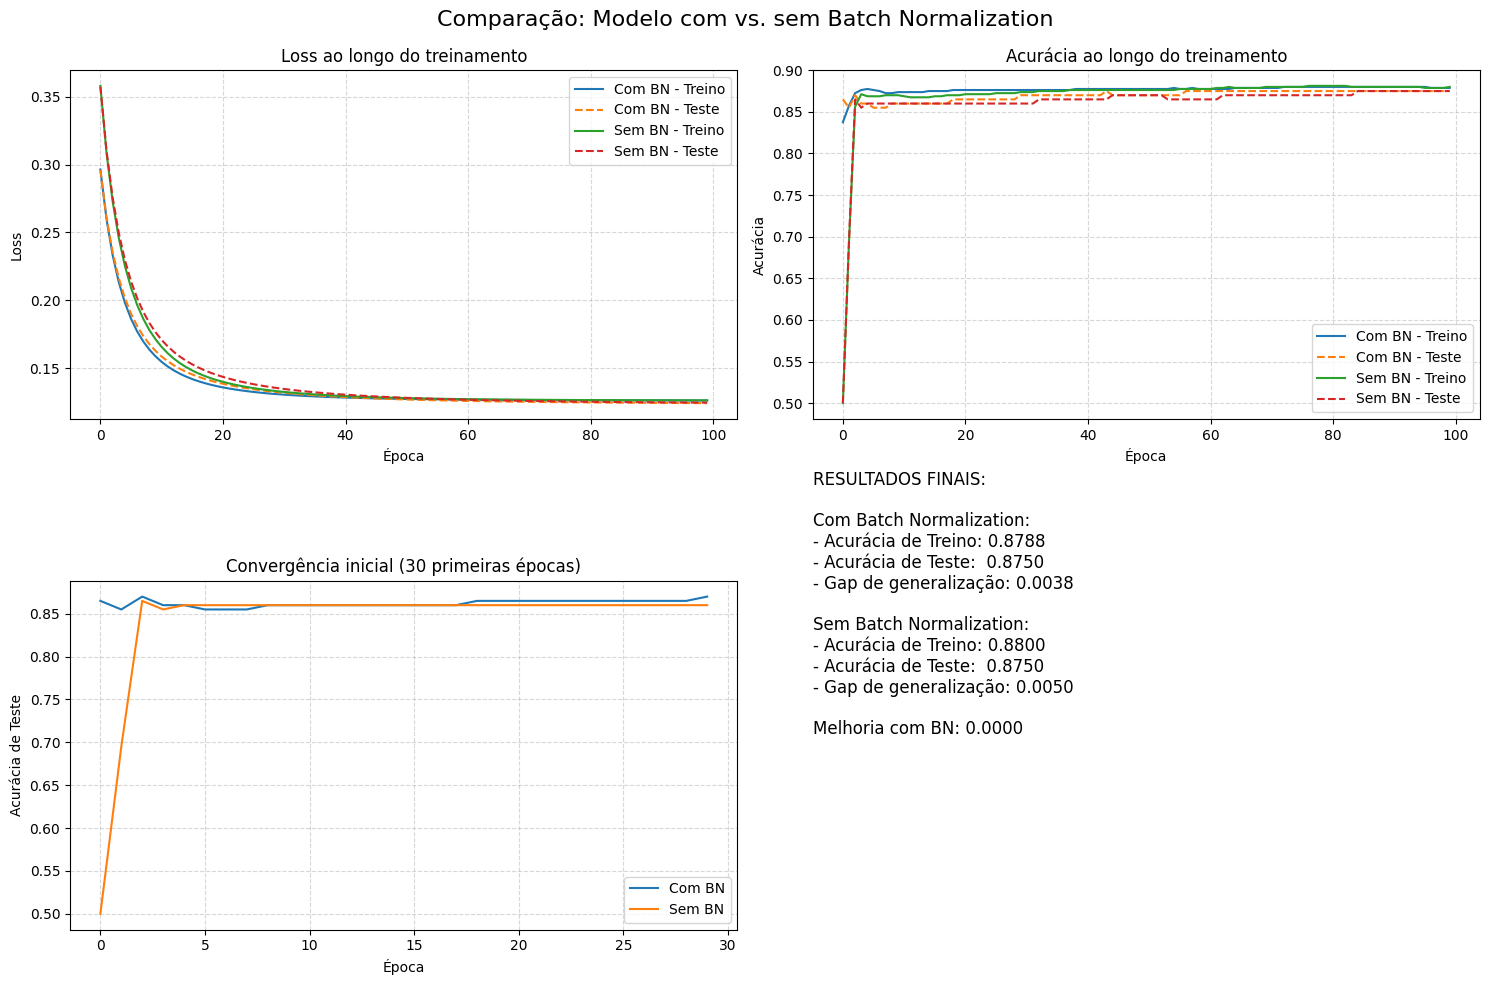

In [57]:
# Comparação de desempenho: com e sem Batch Normalization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Gera um conjunto de dados sintético para classificação binária
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Converte y para formato one-hot
y_train_onehot = np.zeros((y_train.shape[0], 2))
y_train_onehot[np.arange(y_train.shape[0]), y_train] = 1

y_test_onehot = np.zeros((y_test.shape[0], 2))
y_test_onehot[np.arange(y_test.shape[0]), y_test] = 1

class MLP:
    def __init__(self, input_size, hidden_size, output_size, activation, learning_rate, weight_init, use_batch_norm=False):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.use_batch_norm = use_batch_norm
        self._initialize_weights()
        self._initialize_activations()

    def _initialize_activations(self):
        if self.activation == "relu":
            self.activation_func = lambda x: np.maximum(0, x)
            self.activation_derivative = lambda x: (x > 0).astype(float)
        elif self.activation == "sigmoid":
            self.activation_func = lambda x: 1 / (1 + np.exp(-x))
            self.activation_derivative = lambda x: x * (1 - x)
        else:
            raise ValueError(f"Unknown activation function: {self.activation}")

    def _initialize_weights(self):
        if self.weight_init == "he":
            limit = np.sqrt(6 / (self.input_size + self.hidden_size))
            self.weights = {
                "W1": np.random.uniform(-limit, limit, (self.input_size, self.hidden_size)),
                "W2": np.random.uniform(-limit, limit, (self.hidden_size, self.output_size))
            }
        elif self.weight_init == "xavier":
            limit = np.sqrt(2 / (self.input_size + self.hidden_size))
            self.weights = {
                "W1": np.random.uniform(-limit, limit, (self.input_size, self.hidden_size)),
                "W2": np.random.uniform(-limit, limit, (self.hidden_size, self.output_size))
            }
        else:
            raise ValueError(f"Unknown weight initialization method: {self.weight_init}")
        if self.use_batch_norm:
            self.bn_params = {
                "gamma": np.ones((1, self.hidden_size)),
                "beta": np.zeros((1, self.hidden_size)),
                "moving_mean": np.zeros((1, self.hidden_size)),
                "moving_var": np.ones((1, self.hidden_size))
            }
            self.bn_momentum = 0.9
            self.bn_epsilon = 1e-5
            self.bn_running_mean = np.zeros((1, self.hidden_size))
            self.bn_running_var = np.ones((1, self.hidden_size))
            self.bn_training = True
            self.bn_cache = {}
            self.bn_cache["Z1"] = None
            self.bn_cache["A1"] = None
            self.bn_cache["Z2"] = None
            self.bn_cache["A2"] = None
        else:
            self.bn_cache = None
    def forward(self, X):
        # Forward pass
        self.Z1 = np.dot(X, self.weights["W1"])
        self.A1 = self.activation_func(self.Z1)
        self.Z2 = np.dot(self.A1, self.weights["W2"])
        self.A2 = np.exp(self.Z2) / np.sum(np.exp(self.Z2), axis=1, keepdims=True)  # Softmax
        return self.A2

    def backward(self, X, y, y_pred):
        # Backward pass
        dZ2 = y_pred - y
        dW2 = np.dot(self.A1.T, dZ2) / X.shape[0]
        dA1 = np.dot(dZ2, self.weights["W2"].T)
        dZ1 = dA1 * self.activation_derivative(self.A1)
        dW1 = np.dot(X.T, dZ1) / X.shape[0]

        # Update weights
        self.weights["W1"] -= self.learning_rate * dW1
        self.weights["W2"] -= self.learning_rate * dW2

# Cria dois modelos idênticos, exceto pelo uso de BatchNorm
model_with_bn = MLP(
    input_size=2,
    hidden_size=64,
    output_size=2,
    activation="relu",
    learning_rate=0.01,
    weight_init="he",
    use_batch_norm=True
)

model_without_bn = MLP(
    input_size=2,
    hidden_size=64,
    output_size=2,
    activation="relu",
    learning_rate=0.01,
    weight_init="he",
    use_batch_norm=False
)


model_without_bn = MLP(
    input_size=2,
    hidden_size=64,
    output_size=2,
    activation="relu",
    learning_rate=0.01,
    weight_init="he"
)

# Função para treinar e coletar histórico
def train_and_collect_history(model, X_train, y_train, X_test, y_test, epochs=100):
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    
    batch_size = 32
    n_batches = int(np.ceil(len(X_train) / batch_size))
    
    for epoch in range(epochs):
        # Embaralha os dados
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_onehot[indices]
        
        epoch_loss = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(X_train))
            
            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]
            
            # Forward pass
            y_pred = model.forward(X_batch)
            
            # Calcula perda
            batch_loss = -np.mean(y_batch * np.log(y_pred + 1e-10))
            epoch_loss += batch_loss
            
            # Backward pass e atualização
            model.backward(X_batch, y_batch, y_pred)
            
            # model.update_weights() 
    
        # Calcula métricas de treino
        y_train_pred = model.forward(X_train)
        train_loss = -np.mean(y_train_onehot * np.log(y_train_pred + 1e-10))
        train_acc = np.mean(np.argmax(y_train_pred, axis=1) == y_train)
        
        # Calcula métricas de teste
        y_test_pred = model.forward(X_test)
        test_loss = -np.mean(y_test_onehot * np.log(y_test_pred + 1e-10))
        test_acc = np.mean(np.argmax(y_test_pred, axis=1) == y_test)
        
        # Registra histórico
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
                  f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")
    
    return history

# Treina os modelos
print("Treinando modelo com Batch Normalization...")
history_bn = train_and_collect_history(model_with_bn, X_train, y_train, X_test, y_test)

print("\nTreinando modelo sem Batch Normalization...")
history_no_bn = train_and_collect_history(model_without_bn, X_train, y_train, X_test, y_test)

# Visualização dos resultados
plt.figure(figsize=(15, 10))

# Plot de Loss
plt.subplot(2, 2, 1)
plt.plot(history_bn["train_loss"], label="Com BN - Treino")
plt.plot(history_bn["test_loss"], label="Com BN - Teste", linestyle="--")
plt.plot(history_no_bn["train_loss"], label="Sem BN - Treino")
plt.plot(history_no_bn["test_loss"], label="Sem BN - Teste", linestyle="--")
plt.title("Loss ao longo do treinamento")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

# Plot de Acurácia
plt.subplot(2, 2, 2)
plt.plot(history_bn["train_acc"], label="Com BN - Treino")
plt.plot(history_bn["test_acc"], label="Com BN - Teste", linestyle="--")
plt.plot(history_no_bn["train_acc"], label="Sem BN - Treino")
plt.plot(history_no_bn["test_acc"], label="Sem BN - Teste", linestyle="--")
plt.title("Acurácia ao longo do treinamento")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

# Gráfico para mostrar a convergência mais rápida com Batch Norm
plt.subplot(2, 2, 3)
plt.plot(history_bn["test_acc"][:30], label="Com BN")
plt.plot(history_no_bn["test_acc"][:30], label="Sem BN")
plt.title("Convergência inicial (30 primeiras épocas)")
plt.xlabel("Época")
plt.ylabel("Acurácia de Teste")
plt.legend()
plt.grid(True, ls="--", alpha=0.5)

# Tabela de resultados como texto
plt.subplot(2, 2, 4)
plt.axis('off')
final_bn_train = history_bn["train_acc"][-1]
final_bn_test = history_bn["test_acc"][-1]
final_no_bn_train = history_no_bn["train_acc"][-1]
final_no_bn_test = history_no_bn["test_acc"][-1]

text = f"""RESULTADOS FINAIS:

Com Batch Normalization:
- Acurácia de Treino: {final_bn_train:.4f}
- Acurácia de Teste:  {final_bn_test:.4f}
- Gap de generalização: {final_bn_train - final_bn_test:.4f}

Sem Batch Normalization:
- Acurácia de Treino: {final_no_bn_train:.4f}
- Acurácia de Teste:  {final_no_bn_test:.4f}
- Gap de generalização: {final_no_bn_train - final_no_bn_test:.4f}

Melhoria com BN: {final_bn_test - final_no_bn_test:.4f}
"""
plt.text(0, 0.5, text, fontsize=12)

plt.tight_layout()
plt.suptitle("Comparação: Modelo com vs. sem Batch Normalization", fontsize=16)
plt.subplots_adjust(top=0.92)